# Denoising Diffusion Probabilistic Models with miniai

We want to "fix the bug" of feeding into our Unet in ddpmV2 original ddpm images that go from zero to one.
Everybody feeds in images that are from -1 to 1, so it is easy to fix.
"Everybody knows it's a bug because that's what everybody does", nobody does anything else,
and it's very easy to fix so JH fixed it by adding this to ddpmv2, re-ran it and it didn't work, it made it worse.
When you fix a bug and it makes things worse, it generally suggests there's some other bug 
somewhere else that somehow is offset by the first.

Maybe what everybody does is not the right thing to do, given that it seemed like fixing the bug made it worse maybe not.
We are confident that having centered data is better than uncentered data.
Having data go from zero to one is weird, maybe the issue is not that we've changed the center, 
but that we've scaled it down.
Rather than having a range of 2 it's got a range of 1.
Then subtracted 0.5 so now it goes from -0.5 to 0.5.
If the hypothesis is correct, that the -1 to 1 range has no foundational reason for being,
and we've accidentally hit on that a range of 1 is better than a range of 2.
Then this should be better because this is a range of 1 and it's centered properly.
This is DDPMV3, ran that and yes it is better.
Now we've got FID, so I was able to run fit on ddpmv2 and on ddpmv3 and it was much better.
JH run a lot of other experiments at the time, and all experiments were fallen apart,
then when fixed the bug, all the things that I thought weren't working suddenly started working.
<br>
<mark>Bugs can result in accidental discoveries, and the trick is always to recognize when that's happened.</mark>

## Imports

In [1]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *

In [2]:
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

In [3]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))-0.5 for o in b[xl]]

bs = 512
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=8)

  0%|          | 0/2 [00:00<?, ?it/s]

Started looking at our schedule, we'd always been copying and pasting this standard 
again set of stuff and I started questioning everything I was like why is this the standard.
Why are these numbers here and I don't see any particular reason why those numbers were there.
We should experiment with them.

In [4]:
from types import SimpleNamespace

To make it easier created a little function that would return a schedule.
We could create a new class or a schedule.
Python is called namespace which is like a struct in C,
lets us wrap up a bunch of keys and values as if it's an object.
JH coded a simple namespace which contains our Alphas, Alphabars, sigmas, for our normal beta Max access 0.02.

In [5]:
def linear_sched(betamin=0.0001,betamax=0.02,n_steps=1000):
    beta = torch.linspace(betamin, betamax, n_steps)
    return SimpleNamespace(a=1.-beta, abar=(1.-beta).cumprod(dim=0), sig=beta.sqrt())

In [6]:
def abar(t, T): return (t/T*math.pi/2).cos()**2

There's another paper with a cosine schedule where we set Alphabar equal to t as a fraction of Big T times pi over 2 cosine of that squared.
If we make that our Alphabar we can reverse back out to calculate what Alpha must have been, 
and so we can create a cosine schedule.

In [7]:
def cos_sched(n_steps=1000):
    ts = torch.linspace(0, n_steps-1, n_steps)
    ab = abar(ts,n_steps)
    alp = ab/abar(ts-1,n_steps)
    return SimpleNamespace(a=alp, abar=ab, sig=(1-alp).sqrt())

A cosine schedule is better than a linear schedule, so lets compare them.
All that matters is alphabar, the total amount of noise that we're adding.
In ddpm when we do noiseify it is alphabar that we use,
Plotted those for a normal linear schedule and cosine schedule.
The linear schedule is bad, it's got a lot of time steps where it's basically zero, and we can't do anything with zero.
The cosine schedule is nice and smooth, not as many steps nearly zero or nearly one.

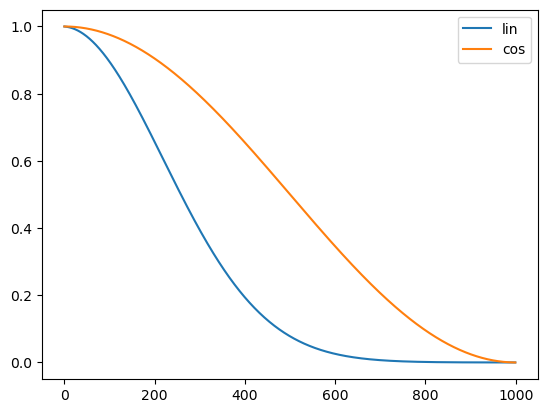

In [8]:
lin_abar = linear_sched().abar
cos_abar = cos_sched().abar
plt.plot(lin_abar, label='lin')
plt.plot(cos_abar, label='cos')
plt.legend();

The slope of these curves indicates how much things are stepping during the sampling process.
Here's the slope of the lin and the cosine, the cosine slope is a nice smooth curve,
but the linear slope is just a "disaster".

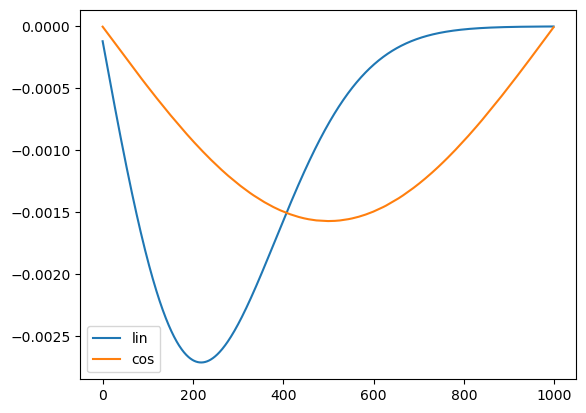

In [9]:
plt.plot(lin_abar[1:]-lin_abar[:-1], label='lin')
plt.plot(cos_abar[1:]-cos_abar[:-1], label='cos')
plt.legend();

Was inclined to use the cosine schedule, but then realized it will be easy to get rid of the big flat bit,
by just decreasing `betamax`.

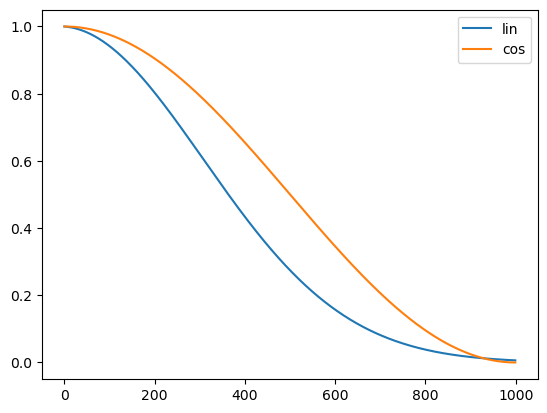

In [10]:
lin_abar = linear_sched(betamax=0.01).abar
plt.plot(lin_abar, label='lin')
plt.plot(cos_abar, label='cos')
plt.legend();

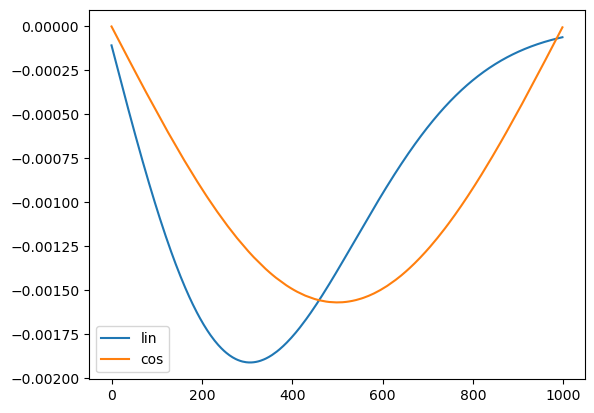

In [11]:
plt.plot(lin_abar[1:]-lin_abar[:-1], label='lin')
plt.plot(cos_abar[1:]-cos_abar[:-1], label='cos')
plt.legend();

The change of betaMax to 0.01 gives nearly the same curve as the cosine, why everybody always use 0.02 as a default?
The lead authors on the stable diffusion paper experimented and noticed that a decreased betaMax got better results.
Stable diffusion uses betaMax 0.012, but it's certainly a lot better than the normal default.
They have a magical factor of 0.1802 to scale the latents which also is reducing the range of the inputs.
We both independently discovered this idea.
Here's the curves are also pretty close so we would like to change as little as possible,
so we keep using a linear schedule but change betamax to 0.01. for the next version of ddpm.

A linear schedule `betamax=0.01` to avoid changing any of the code.
Then just put those in the same variable names that we've always used so that noise is the same as always. And repeat everything as before.

In [12]:
n_steps = 1000
lin_abar = linear_sched(betamax=0.01)
alphabar = lin_abar.abar
alpha = lin_abar.a
sigma = lin_abar.sig

In [13]:
def noisify(x0, ᾱ):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
    return (xt, t.to(device)), ε

In [14]:
dt = dls.train
xb,yb = next(iter(dt))

In [15]:
(xt,t),ε = noisify(xb[:25],alphabar)
t

tensor([876, 414,  26, 335, 620, 924, 950, 113, 378,  14, 210, 954, 231, 572,
        315, 295, 567, 706, 749, 876,  73, 111, 899, 213, 541])

Now a batch of data has more recognizable images.
This is encouraging, previously almost all images have been Pure Noise (not a good sign).

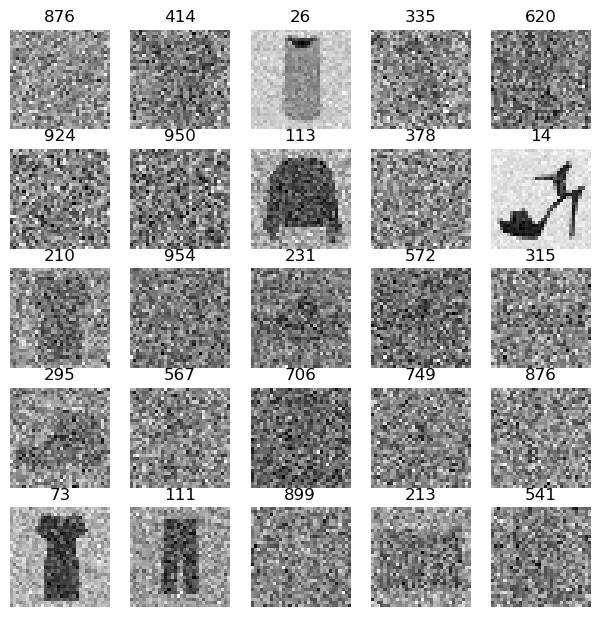

In [16]:
titles = fc.map_ex(t[:25], '{}')
show_images(xt[:25], imsize=1.5, titles=titles)

## Training

Now we train it the same as ddpmv2, and save the model as 
`torch.save(learn.model, mdl_path/'fashion_ddpm3_25.pkl')`
As it was going well, doubled the sizes all the channels from v2, increased the number of epochs to 25, 
to make a bigger model trained for longer.

In [17]:
from diffusers import UNet2DModel

In [18]:
class UNet(UNet2DModel):
    def forward(self, x): return super().forward(*x).sample

In [19]:
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

In [20]:
def collate_ddpm(b): return noisify(default_collate(b)[xl], alphabar)
def dl_ddpm(ds, nw=4): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=nw)

In [21]:
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

In [22]:
lr = 1e-2
epochs = 25
opt_func = partial(optim.AdamW, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), MixedPrecision(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
model = UNet(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 256), norm_num_groups=8)
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

/Users/germangoldszmidt/mambaforge/lib/python3.9/site-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


loss,epoch,train
0.195,0,train
0.043,0,eval
0.037,1,train
0.038,1,eval
0.032,2,train
0.030,2,eval
0.029,3,train
0.028,3,eval


/Users/germangoldszmidt/mambaforge/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


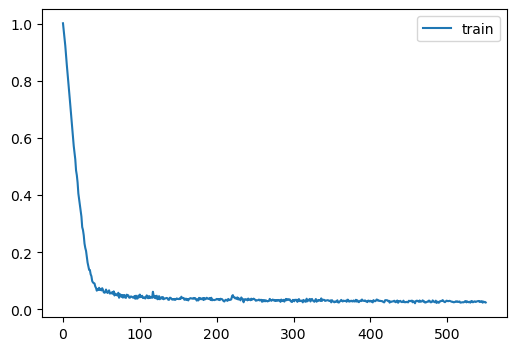

In [ ]:
learn.fit(epochs)

In [ ]:
mdl_path = Path('models')

In [ ]:
# torch.save(learn.model, mdl_path/'fashion_ddpm3_25.pkl')

In [ ]:
model = torch.load(mdl_path/'fashion_ddpm3_25.pkl').cuda()

In [ ]:
@torch.no_grad()
def sample(model, sz):
    ps = next(model.parameters())
    x_t = torch.randn(sz).to(ps)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=ps.device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(ps)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1-alphabar[t]
        b̄_t1 = 1-ᾱ_t1
        noise = model((x_t, t_batch))
        x_0_hat = ((x_t - b̄_t.sqrt() * noise)/alphabar[t].sqrt())
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        preds.append(x_t.float().cpu())
    return preds

`sample` is the same, we create `n_samples=512` generated samples.

In [ ]:
n_samples = 512

In [ ]:
%%time
samples = sample(model, (n_samples, 1, 32, 32))

In [ ]:
s = (samples[-1]*2)#.clamp(-1,1)
s.min(),s.max()

They look great, we couldn't recognize them from the real samples.

In [ ]:
show_images(s[:16], imsize=1.5)

Now we can test them, so we load up the aug2 model, delete the last two layers

In [ ]:
@inplace
def transformi2(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]

tds2 = dsd.with_transform(transformi2)
dls2 = DataLoaders.from_dd(tds2, bs, num_workers=fc.defaults.cpus)

cmodel = torch.load('models/data_aug2.pkl')
del(cmodel[8])
del(cmodel[7])

Pass that to `ImageEval` and get a FID for our samples of 8.
Chose 512 because that's our batch size so then we can compare with the FID for the actual data at 6.6.
This is a FID that is nearly as good as real images.
In terms of image quality for small unconditional generated sampling we're "done".

In [ ]:
from miniai.fid import ImageEval

In [ ]:
ie = ImageEval(cmodel, dls2, cbs=[DeviceCB()])

In [ ]:
ie.fid(s)

In [ ]:
s.min(),s.max()

In [ ]:
ie.fid(xb*2)

### Skip sampling

Can we make it faster at the same quality? 
We call the sample loop 1000 times, i.e., we're running the model 1000 times, 
and most of the time we just move a tiny bit, so the model is pretty much the same, 
as the noise being predicted is very much the same.
Let's only call the model every third time, and also the last 50 times to help it fine tune.

In [ ]:
@torch.no_grad()
def sample_skip(model, sz):
    ps = next(model.parameters())
    x_t = torch.randn(sz).to(ps)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=ps.device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(ps)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1-alphabar[t]
        b̄_t1 = 1-ᾱ_t1
        if t%3==0 or t<50: noise = model((x_t, t_batch))
        x_0_hat = ((x_t - b̄_t.sqrt() * noise)/alphabar[t].sqrt())
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        preds.append(x_t.cpu().float())
    return preds

This is approximately 3 times faster, samples look basically the same, and FID is 9.78 versus 8.1,
within the normal variance.
We have to run this a few times or use bigger samples to validate.
It is showing that we probably don't need to call the model 1000 times.

In [ ]:
%%time
samples = sample_skip(model, (n_samples, 1, 32, 32))

In [ ]:
s = (samples[-1]*2)#.clamp(-1,1)

In [ ]:
show_images(s[:25], imsize=1.5)

In [ ]:
ie.fid(s)

Another slightly weird thing is create a different schedule for how often we call the model.
`sample_at = {t for t in range(n_steps) if (t+101)%((t+101)//100)==0}`
For the first few time steps, just do it every 10 and then for the next two every nine,
and then the next few every eight, and so forth.
And just for the last hundred do it every step.
It makes it faster, but the FID is worse, but still not bad.

In [ ]:
@torch.no_grad()
def sample2(model, sz):
    ps = next(model.parameters())
    x_t = torch.randn(sz).to(ps)
    sample_at = {t for t in range(n_steps) if (t+101)%((t+101)//100)==0}
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=ps.device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(ps)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1-alphabar[t]
        b̄_t1 = 1-ᾱ_t1
        if t in sample_at: noise = model((x_t, t_batch))
        x_0_hat = ((x_t - b̄_t.sqrt() * noise)/alphabar[t].sqrt())
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        if t in sample_at: preds.append(x_t.float().cpu())
    return preds

In [ ]:
%%time
samples = sample2(model, (n_samples, 1, 32, 32))

In [ ]:
s = (samples[-1]*2)#.clamp(-1,1)

In [ ]:
show_images(s[:25], imsize=1.5)

In [ ]:
ie.fid(s)

We can create extremely high quality samples using DDPM.